## Access Zarr Data to understand changes in northern hemisphere sea ice 

This notebook builds upon notebook #5 from the ESA CCI Toolbox: 5-ECY_Zarr_Access.ipynb to visualse Sea Ice in the Northern Hemisphere, using data from Cryosat-2. The notebook spatially plots the sea ice thickness over the period 2011-2017, as well as the average sea ice thickness and sea ice concentration over the same period.


In [68]:
from xcube.core.store import new_data_store

In [69]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [70]:
zarr_store = new_data_store('esa-cci-zarr')

We access the "ESACCI-SEAICE-L3C-SITHICK-SIRAL_CRYOSAT2-NH25KMEASE2-2010-2017-fv2.0.zarr" dataset from the Zarr data store. This is a six-year dataset covering the northern hemisphere. You can see more about the data attributes below, under the 'attrs' item.

The data variables we will investigate in this notebook are the sea ice thickness and the sea ice concentration. As you can see below, there are a number of other related variables which you can also explore.

In [71]:
zarr_store.describe_data('ESACCI-SEAICE-L3C-SITHICK-SIRAL_CRYOSAT2-NH25KMEASE2-2010-2017-fv2.0.zarr')

Open the data cube for this dataset

In [72]:
cube = zarr_store.open_data('ESACCI-SEAICE-L3C-SITHICK-SIRAL_CRYOSAT2-NH25KMEASE2-2010-2017-fv2.0.zarr')
cube

<xarray.Dataset> Size: 263MB
Dimensions:                        (time: 48, yc: 432, xc: 432, nv: 2)
Coordinates:
    lat                            (yc, xc) float64 1MB dask.array<chunksize=(432, 432), meta=np.ndarray>
    lon                            (yc, xc) float64 1MB dask.array<chunksize=(432, 432), meta=np.ndarray>
  * time                           (time) datetime64[ns] 384B 2010-11-01 ... ...
    time_bnds                      (time, nv) datetime64[ns] 768B dask.array<chunksize=(24, 2), meta=np.ndarray>
  * xc                             (xc) float64 3kB -5.388e+03 ... 5.388e+03
  * yc                             (yc) float64 3kB 5.388e+03 ... -5.388e+03
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid         int8 1B ...
    freeboard                      (time, yc, xc) float32 36MB dask.array<chunksize=(24, 432, 432), meta=np.ndarray>
    freeboard_uncertainty          (time, yc, xc) float32 36MB dask.array<chunksize=(24, 432, 432), meta=np.ndarray>
    radar_freeboard                (time, yc, xc) float32 36MB dask.array<chunksize=(24, 432, 432), meta=np.ndarray>
    radar_freeboard_uncertainty    (time, yc, xc) float32 36MB dask.array<chunksize=(24, 432, 432), meta=np.ndarray>
    sea_ice_concentration          (time, yc, xc) float32 36MB dask.array<chunksize=(24, 432, 432), meta=np.ndarray>
    sea_ice_thickness              (time, yc, xc) float32 36MB dask.array<chunksize=(24, 432, 432), meta=np.ndarray>
    sea_ice_thickness_uncertainty  (time, yc, xc) float32 36MB dask.array<chunksize=(24, 432, 432), meta=np.ndarray>
    status_flag                    (time, yc, xc) int8 9MB dask.array<chunksize=(24, 432, 432), meta=np.ndarray>
Attributes: (12/37)
    cdm_data_type:             Grid
    comment:                   Northern hemisphere sea ice thickness coverage...
    conventions:               CF-1.6
    creator_email:             stefan.hendricks@awi.de, stephan.paul@awi.de, ...
    creator_name:              Stefan Hendricks, Stephan Paul (Alfred Wegener...
    creator_url:               http://www.awi.de
    ...                        ...
    time_coverage_duration:    P1M
    time_coverage_end:         19700101T000001
    time_coverage_resolution:  P1M
    time_coverage_start:       19700101T000001
    title:                     ESA Climate Change Initiative Sea Ice: Norther...
    tracking_id:               6a71bb60-e10b-4dca-a50c-c79a13bc3393

## Visualising the data

We can now plot the data, to visuale change in sea ice

In [73]:
import matplotlib.pyplot as plt

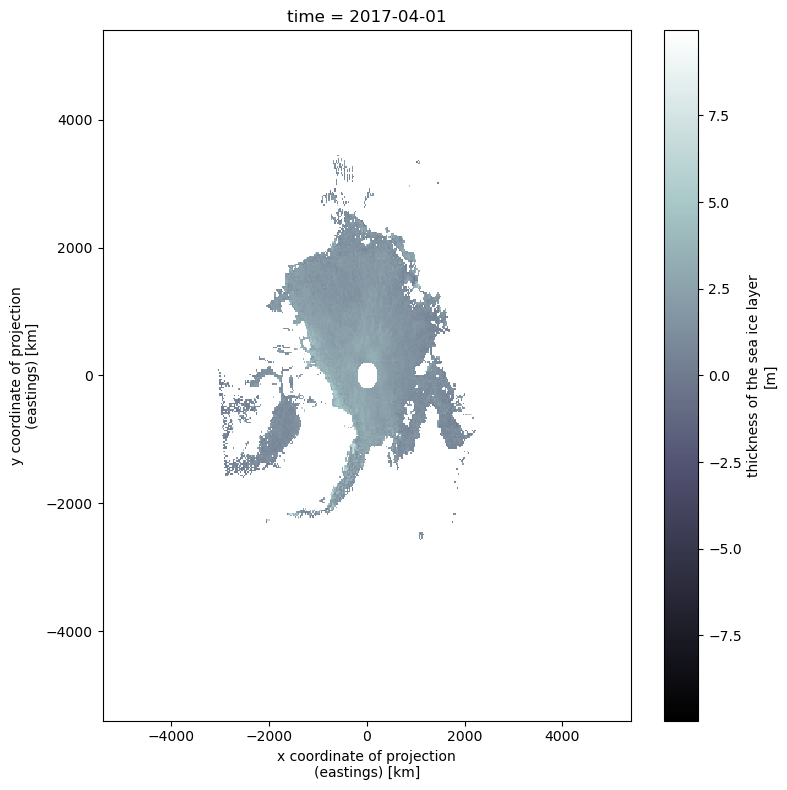

In [86]:
# plot a single time point
cube.sea_ice_thickness.sel(time='2017-11-01 12:00:00', method='nearest').plot.imshow(cmap='bone', figsize=(8, 8))
plt.show()
plt.close()

In [87]:
times = cube.time

To visualse how the sea ice changes over the dataset period, we create an animated gif, plotting each time point in the dataset. The gif is saved locally. 

Note: the below cell make take some time to run.

In [88]:
# Install libraries
!pip install imageio

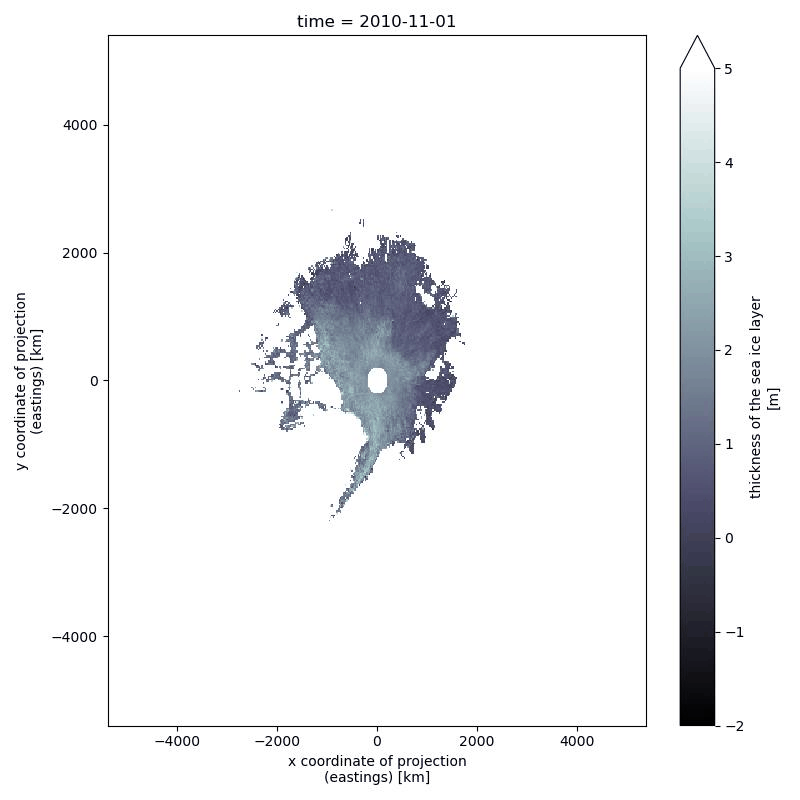

In [89]:
# Import necessary libraries
import imageio
import matplotlib.pyplot as plt
from io import BytesIO
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Parameters
delay = 1.0  # Delay between frames in seconds

# Generate plots for the whole timeseries and store them in memory
images = []

for i in range(len(times)):
    t = times[i]
    fig, ax = plt.subplots(figsize=(8, 8))
    cube.sea_ice_thickness.sel(time=t, method='nearest').plot.imshow(cmap='bone', ax=ax, vmin=-2, vmax=5)
    buf = BytesIO()
    plt.savefig(buf, format='jpg')
    buf.seek(0)
    images.append(imageio.imread(buf))
    plt.close(fig)

# Create the animated GIF from the images in memory
gif_filename = 'seaIceAnimation.gif'
imageio.mimsave(gif_filename, images, duration=delay)

# Display the animated GIF in the notebook
from IPython.display import Image
Image(filename=gif_filename)


## Quantifying the data
But how can we quantify the change? Below we look at the average sea ice thickness and sea ice concentration at each time point over the period, and plot it on a chart.

The below builds off notebook 8 in the ESA CCI Toolbox: '8-ECT_Using_Operations.ipynb'

In [90]:
import esa_climate_toolbox.ops as ops

from esa_climate_toolbox.core import get_op
from esa_climate_toolbox.core import get_op_meta_info
from esa_climate_toolbox.util.monitor import ConsoleMonitor

In [91]:
svar_op = get_op('select_var')

In [92]:
seaice_concentration_ds = svar_op(ds=cube, var='sea_ice_concentration')
seaice_concentration_ds

<xarray.Dataset> Size: 39MB
Dimensions:                (yc: 432, xc: 432, time: 48, nv: 2)
Coordinates:
    lat                    (yc, xc) float64 1MB dask.array<chunksize=(432, 432), meta=np.ndarray>
    lon                    (yc, xc) float64 1MB dask.array<chunksize=(432, 432), meta=np.ndarray>
  * time                   (time) datetime64[ns] 384B 2010-11-01 ... 2017-04-01
    time_bnds              (time, nv) datetime64[ns] 768B dask.array<chunksize=(24, 2), meta=np.ndarray>
  * xc                     (xc) float64 3kB -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                     (yc) float64 3kB 5.388e+03 5.362e+03 ... -5.388e+03
Dimensions without coordinates: nv
Data variables:
    sea_ice_concentration  (time, yc, xc) float32 36MB dask.array<chunksize=(24, 432, 432), meta=np.ndarray>
Attributes: (12/37)
    cdm_data_type:             Grid
    comment:                   Northern hemisphere sea ice thickness coverage...
    conventions:               CF-1.6
    creator_email:             stefan.hendricks@awi.de, stephan.paul@awi.de, ...
    creator_name:              Stefan Hendricks, Stephan Paul (Alfred Wegener...
    creator_url:               http://www.awi.de
    ...                        ...
    time_coverage_duration:    P1M
    time_coverage_end:         19700101T000001
    time_coverage_resolution:  P1M
    time_coverage_start:       19700101T000001
    title:                     ESA Climate Change Initiative Sea Ice: Norther...
    tracking_id:               6a71bb60-e10b-4dca-a50c-c79a13bc3393

In [93]:
seaice_thickness_ds = svar_op(ds=cube, var='sea_ice_thickness')
seaice_thickness_ds

<xarray.Dataset> Size: 39MB
Dimensions:            (yc: 432, xc: 432, time: 48, nv: 2)
Coordinates:
    lat                (yc, xc) float64 1MB dask.array<chunksize=(432, 432), meta=np.ndarray>
    lon                (yc, xc) float64 1MB dask.array<chunksize=(432, 432), meta=np.ndarray>
  * time               (time) datetime64[ns] 384B 2010-11-01 ... 2017-04-01
    time_bnds          (time, nv) datetime64[ns] 768B dask.array<chunksize=(24, 2), meta=np.ndarray>
  * xc                 (xc) float64 3kB -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                 (yc) float64 3kB 5.388e+03 5.362e+03 ... -5.388e+03
Dimensions without coordinates: nv
Data variables:
    sea_ice_thickness  (time, yc, xc) float32 36MB dask.array<chunksize=(24, 432, 432), meta=np.ndarray>
Attributes: (12/37)
    cdm_data_type:             Grid
    comment:                   Northern hemisphere sea ice thickness coverage...
    conventions:               CF-1.6
    creator_email:             stefan.hendricks@awi.de, stephan.paul@awi.de, ...
    creator_name:              Stefan Hendricks, Stephan Paul (Alfred Wegener...
    creator_url:               http://www.awi.de
    ...                        ...
    time_coverage_duration:    P1M
    time_coverage_end:         19700101T000001
    time_coverage_resolution:  P1M
    time_coverage_start:       19700101T000001
    title:                     ESA Climate Change Initiative Sea Ice: Norther...
    tracking_id:               6a71bb60-e10b-4dca-a50c-c79a13bc3393

In [94]:
tseries_point_op = get_op('tseries_point')
tseries_mean_op = get_op('tseries_mean')

In [95]:
seaice_thickness_mean = tseries_mean_op(seaice_thickness_ds, var='sea_ice_thickness')
seaice_concentration_mean = tseries_mean_op(seaice_concentration_ds, var='sea_ice_concentration')

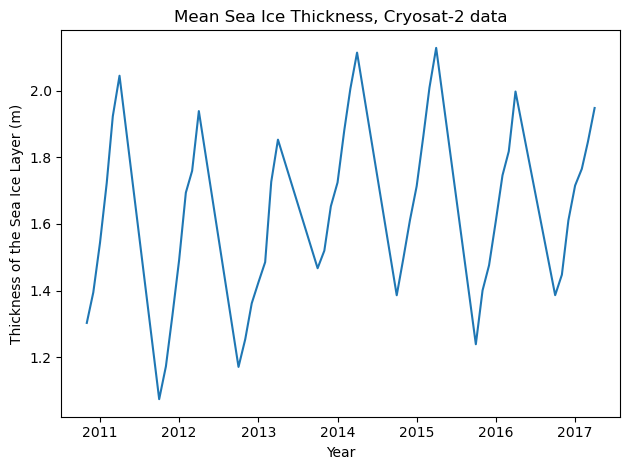

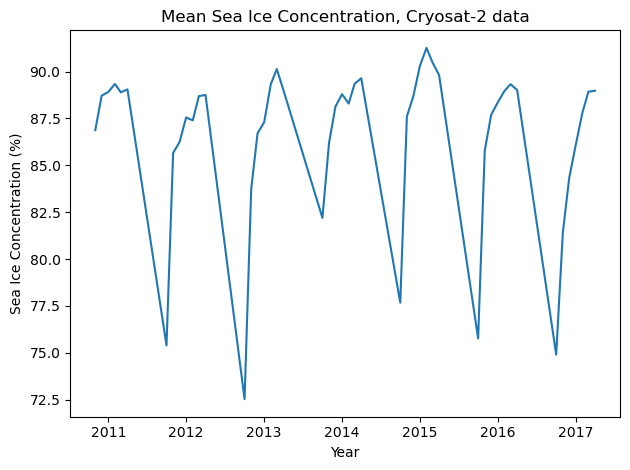

In [96]:
seaice_thickness_mean.sea_ice_thickness_mean.plot()
plt.title("Mean Sea Ice Thickness, Cryosat-2 data")
plt.xlabel("Year")
plt.ylabel("Thickness of the Sea Ice Layer (m)")
plt.show()
plt.close()

seaice_concentration_mean.sea_ice_concentration_mean.plot()
plt.title("Mean Sea Ice Concentration, Cryosat-2 data")
plt.xlabel("Year")
plt.ylabel("Sea Ice Concentration (%)")
plt.show()
plt.close()